In [ ]:
!pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 13.4 MB/s eta 0:00:00


In [ ]:
import torch
import segmentation_models_pytorch as smp

num_classes = 14
device = "cuda" if torch.cuda.is_available() else "cpu"

model_Seg = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=num_classes
)

model_Seg.load_state_dict(torch.load("/content/drive/MyDrive/Modified_With_Lossfunctions.pth", map_location=device))
model_Seg.to(device)
model_Seg .eval()



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

Found 10 images.
Saved mask for img1.jpg at /content/masks/img1_mask.png


/tmp/ipython-input-1197402840.py:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("jet", num_classes)  # Get "jet" colormap with N colors


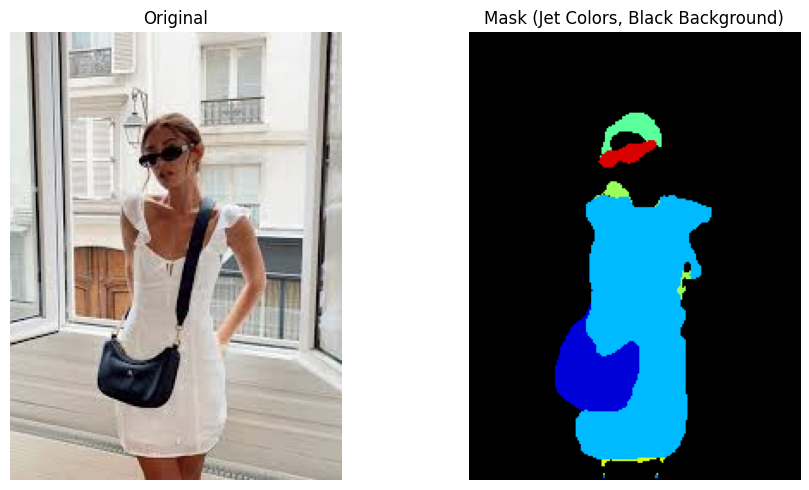

Saved mask for img5.jpg at /content/masks/img5_mask.png


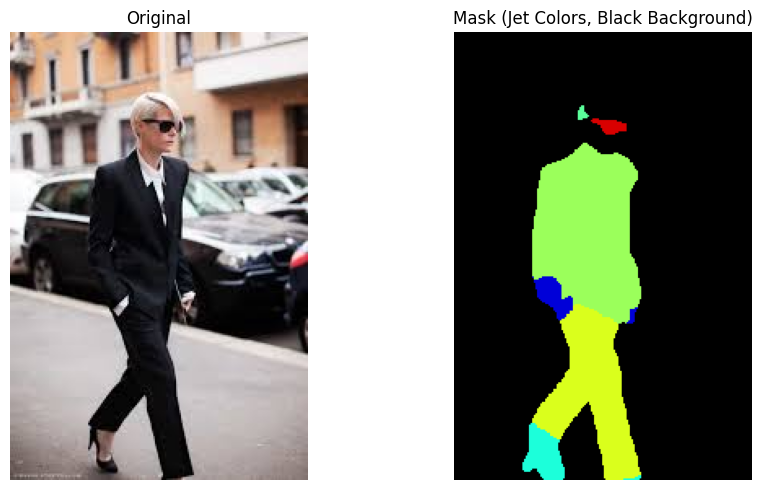

Saved mask for img2.jpg at /content/masks/img2_mask.png


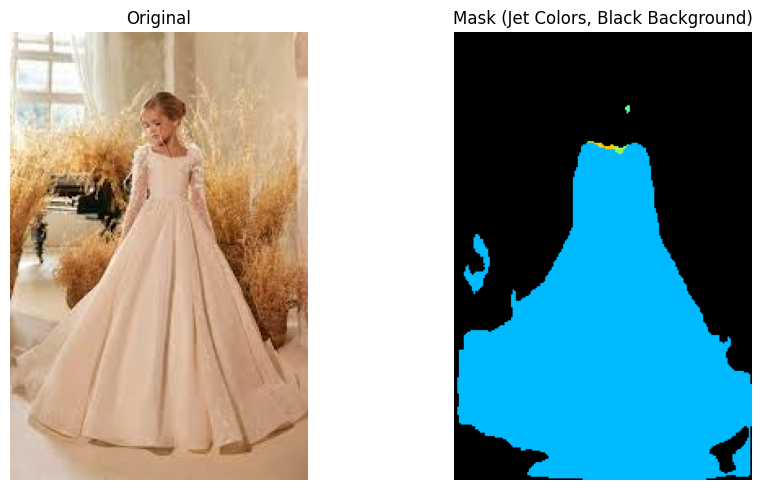

Saved mask for img7.jpg at /content/masks/img7_mask.png


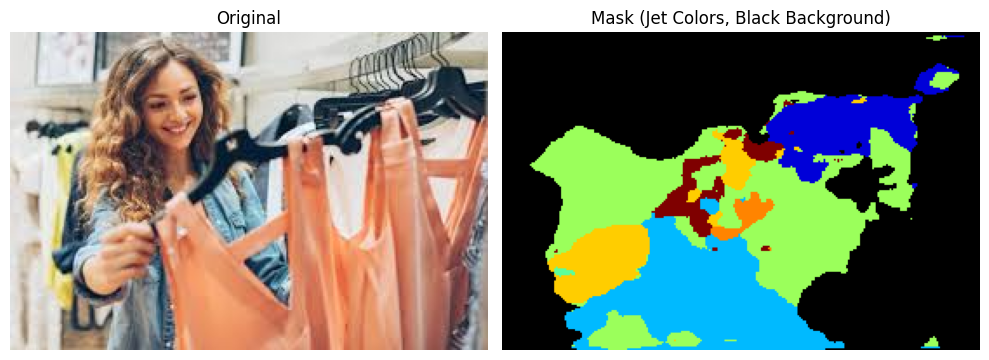

Saved mask for img9.jpg at /content/masks/img9_mask.png


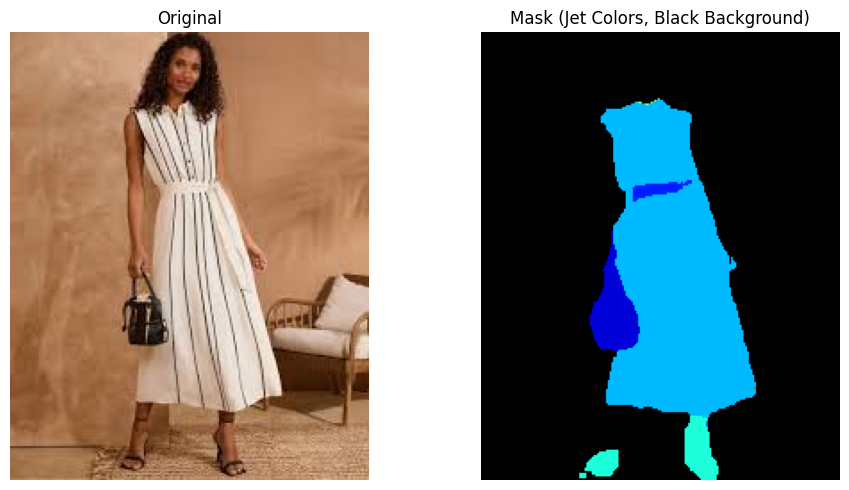

Saved mask for img4.jpg at /content/masks/img4_mask.png


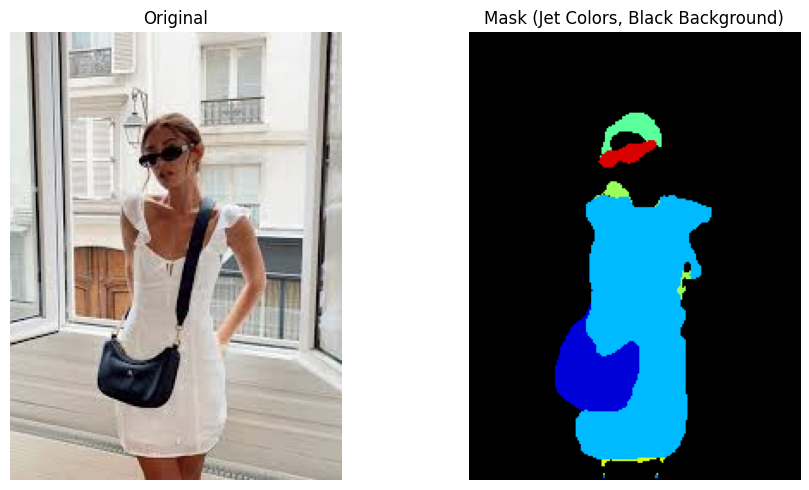

Saved mask for img10.jpg at /content/masks/img10_mask.png


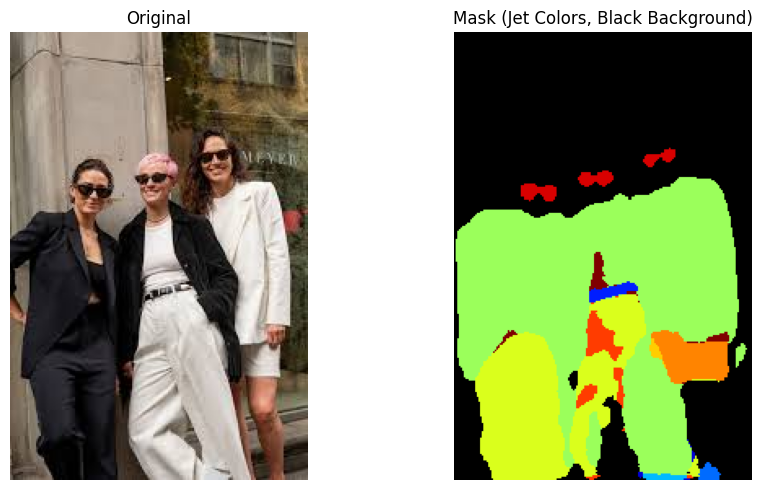

Saved mask for img6.jpg at /content/masks/img6_mask.png


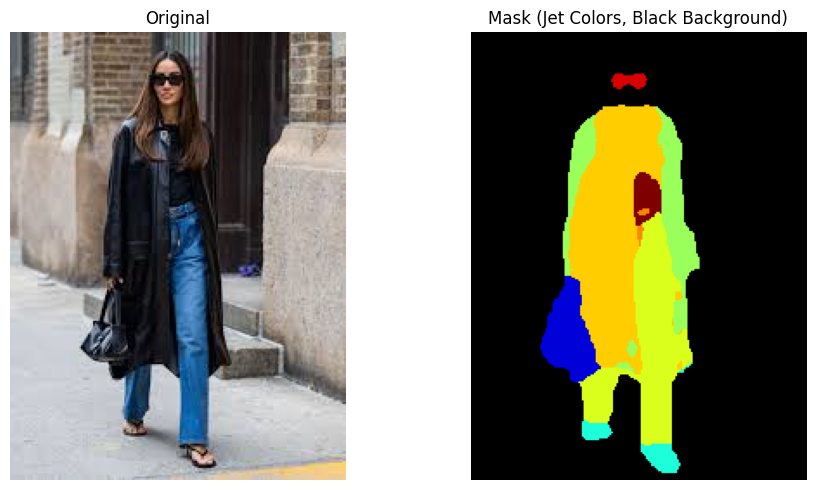

Saved mask for img3.jpg at /content/masks/img3_mask.png


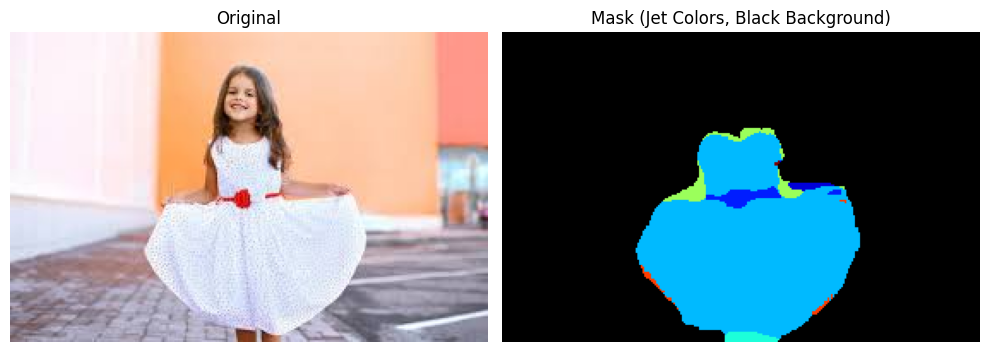

Saved mask for img8.jpg at /content/masks/img8_mask.png


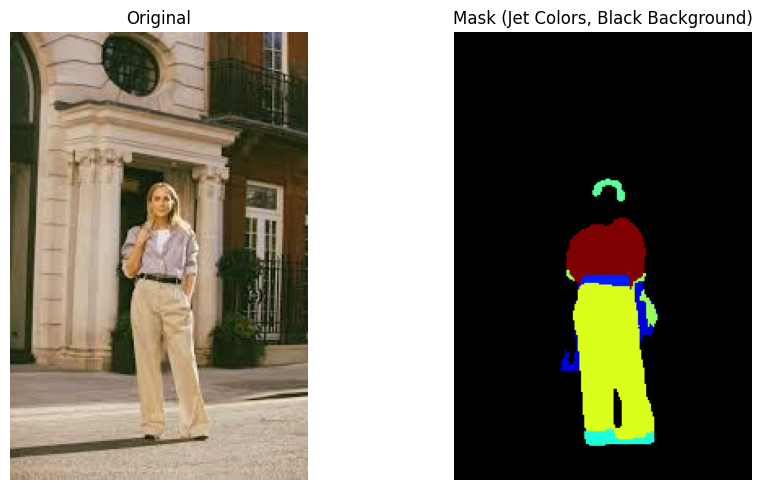

In [ ]:
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import os
from matplotlib import cm

device = "cuda" if torch.cuda.is_available() else "cpu"


image_dir = "/content/images"   
output_dir = "/content/masks"
os.makedirs(output_dir, exist_ok=True)


transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
])


class_names = [
    "background", "bag", "belt", "boots", "dress", "footwear", "headwear",
    "outer", "pants", "scarf-tie", "shorts", "skirt", "sunglasses", "top"
]
num_classes = len(class_names)


image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir)
               if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

print(f"Found {len(image_paths)} images.")

for img_path in image_paths:
    image = Image.open(img_path).convert("RGB")
    orig_size = image.size

    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model_Seg(input_tensor)
        output_resized = torch.nn.functional.interpolate(
            output, size=(orig_size[1], orig_size[0]), mode='nearest'
        )

    pred_mask = torch.argmax(output_resized, dim=1).squeeze(0).cpu().numpy()

  
    cmap = cm.get_cmap("jet", num_classes)  
    colored_mask = np.zeros((*pred_mask.shape, 3), dtype=np.uint8)

    for class_idx in range(1, num_classes):  
        colored_mask[pred_mask == class_idx] = (np.array(cmap(class_idx)[:3]) * 255).astype(np.uint8)

    mask_img = Image.fromarray(colored_mask)
    save_path = os.path.join(output_dir, os.path.basename(img_path).replace('.jpg', '_mask.png'))
    mask_img.save(save_path)
    print(f"Saved mask for {os.path.basename(img_path)} at {save_path}")

   
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(colored_mask)
    plt.title("Mask (Jet Colors, Black Background)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()
